In [19]:
plumber = {(0, 0): (255, 255, 255), (0, 1): (255, 255, 255), (0, 2): (255, 255, 255), (0, 3): (255, 0, 0), (0, 4): (255, 0, 0), (0, 5): (255, 0, 0), (0, 6): (255, 255, 255), (0, 7): (92, 64, 51), (1, 0): (255, 255, 255), (1, 1): (255, 0, 0), (1, 2): (255, 255, 255), (1, 3): (0, 0, 255), (1, 4): (0, 0, 255), (1, 5): (0, 0, 255), (1, 6): (0, 0, 255), (1, 7): (92, 64, 51), (2, 0): (255, 0, 0), (2, 1): (255, 0, 0), (2, 2): (255, 192, 203), (2, 3): (255, 0, 0), (2, 4): (0, 0, 255), (2, 5): (0, 0, 255), (2, 6): (255, 255, 255), (2, 7): (255, 255, 255), (3, 0): (255, 0, 0), (3, 1): (255, 0, 0), (3, 2): (255, 192, 203), (3, 3): (255, 0, 0), (3, 4): (0, 0, 255), (3, 5): (0, 0, 255), (3, 6): (255, 255, 255), (3, 7): (255, 255, 255), (4, 0): (255, 255, 255), (4, 1): (255, 0, 0), (4, 2): (255, 255, 255), (4, 3): (0, 0, 255), (4, 4): (0, 0, 255), (4, 5): (0, 0, 255), (4, 6): (0, 0, 255), (4, 7): (92, 64, 51), (5, 0): (255, 255, 255), (5, 1): (255, 255, 255), (5, 2): (255, 255, 255), (5, 3): (255, 0, 0), (5, 4): (255, 0, 0), (5, 5): (255, 0, 0), (5, 6): (255, 255, 255), (5, 7): (92, 64, 51), (6, 0): (255, 255, 255), (6, 1): (255, 255, 255), (6, 2): (255, 255, 255), (6, 3): (255, 255, 255), (6, 4): (255, 255, 255), (6, 5): (210, 180, 140), (6, 6): (255, 255, 255), (6, 7): (255, 255, 255), (7, 0): (255, 255, 255), (7, 1): (255, 255, 255), (7, 2): (255, 255, 255), (7, 3): (107, 92, 72), (7, 4): (210, 180, 140), (7, 5): (107, 92, 72), (7, 6): (255, 255, 255), (7, 7): (255, 255, 255)}

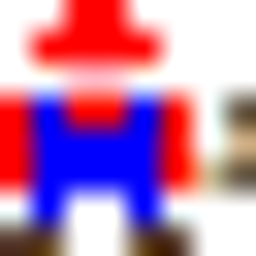

In [20]:
from PIL import Image
from IPython.display import display

def save_image(image, filename='image.png', scale=None):

    img = Image.new('RGB', (8,8))

    for x in range(img.size[0]):
        for y in range(img.size[1]):
            img.load()[x,y] = image[x,y]

    if scale:
        img = img.resize((256,256))

    img.save('outputs/'+filename)

save_image(plumber,scale=[300,300],filename='image1.png')
display(Image.open('outputs/image1.png'))

In [21]:
n = 6

In [34]:
import numpy as np

L = int(2**(n/2))

grid = {}
for y in range(L):
    for x in range(L):
        grid[(x,y)] = ''

for (x,y) in grid:
    for j in range(n):
        if (j%2)==0:
            XX = np.floor(x/2**(j/2))
            grid[(x,y)] = str(int ((XX + np.floor(XX/2)) %2)) + grid[(x,y)]
        else:
            YY = np.floor(y/2**((j-1)/2))
            grid[(x,y)] = str(int ((YY + np.floor(YY/2)) %2)) + grid[(x,y)]

8


In [23]:
def image2state(image,grid):

    N = len(grid)
    state = [[0]*N, [0]*N, [0]*N] # different states for R, G, B

    for pos in image:
        for j in range(3):
            state[j][ int(grid[pos], 2) ] = np.sqrt( image[pos][j] ) # amplitude is square root of color value

    for j in range(3):
        Z = sum(np.absolute(state[j])**2)
        state[j] = [amp / np.sqrt(Z) for amp in state[j]] # amplitudes are normalized

    return state

state = image2state(plumber,grid)

In [24]:
from qiskit_aer import *

backend = Aer.get_backend('statevector_simulator')

In [25]:
def ket2counts (ket):

    counts = {}
    N = len(ket)
    n = int( np.log(N)/np.log(2) ) # figure out the qubit number that this state describes
    for j in range(N):
        string = bin(j)[2:]
        string = '0'*(n-len(string)) + string
        counts[string] = np.absolute(ket[j])**2 # square amplitudes to get probabilities

    return counts

In [26]:
from qiskit import *

q = QuantumRegister(n)

counts = []
for j in range(3): # j=0 for red, j=1 for green, j=2 for blue
    qc = QuantumCircuit(q)
    qc.initialize( state[j],q )
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc)
    counts.append( ket2counts(np.asarray(job.result().get_statevector()) ))

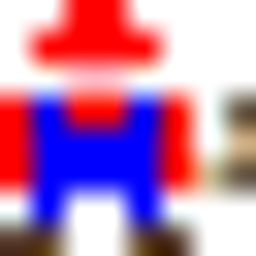

In [27]:
def counts2image(counts,grid):

    image = { pos:[0,0,0] for pos in grid}

    for j in range(3):
        rescale = 255/max(counts[j].values()) # rescale so that largest probability becomes value of 255

        for pos in image:
            try:
                image[pos][j] = int( rescale*counts[j][grid[pos]] )
            except:
                image[pos][j] = int( rescale*counts[j][grid[pos]] )

    for pos in image:
        image[pos] = tuple(image[pos])

    return image

save_image( counts2image(counts,grid), scale=[300,300], filename='image2.png' )
display(Image.open('outputs/image2.png'))

In [28]:
frame_num = 20

In [29]:
from apng import APNG
import os

state = image2state(plumber,grid)

filenames = []
for f in range(frame_num):
    circuits = []
    for j in range(3):
        qc = QuantumCircuit(q)
        qc.initialize(state[j],q)
        qc.ry(2*np.pi*f/frame_num,q)
        circuits.append( qc )

    transpiled_qc = transpile(circuits, backend)
    job = backend.run(transpiled_qc)

    counts = []
    for j in range(3):
        counts.append( ket2counts(np.asarray(job.result().get_statevector(circuits[j])) ) )
        
    frame = counts2image(counts,grid)
    
    filename = 'frame_'+str(f)+'.png'
    save_image( counts2image(counts,grid), scale=[300,300], filename=filename)
    filenames.append( 'outputs/' + filename )

APNG.from_files(filenames,delay=250).save('outputs/animation.png')

for file in filenames:
    os.remove(file)

In [30]:
import ipywidgets as widgets

def make_box():
    children = [widgets.FloatSlider(value=1,max=5.0,step=0.01,description='qubit '+str(qubit),show=True) for qubit in range(n)]
    box = widgets.VBox(children)
    return box

tab = widgets.Tab()
tab.children = [make_box() for j in range(3)]
channels = ['Red Channel','Green Channel','Blue Channel']
for j in range(3):
    tab.set_title(j, channels[j])
    
tab

In [31]:
keywords = {'Topics': ['Creative','Images'], 'Commands': ['`ry`','`initialize`']}

In [32]:
fraction = [[],[],[]]
for j in range(3):
    for qubit in range(n):
        fraction[j].append( tab.children[j].children[qubit].value)

In [33]:
state = image2state(plumber,grid)

filenames = []
for f in range(frame_num):
        
    circuits = []
    for j in range(3):
        qc = QuantumCircuit(q)
        qc.initialize(state[j],q)
        for qubit in range(n):
            qc.ry(2*np.pi*fraction[j][qubit]*f/frame_num,q[qubit])
        circuits.append( qc )

    transpiled_qc = transpile(circuits, backend)
    job = backend.run(transpiled_qc)

    counts = []
    for j in range(3):
        counts.append( ket2counts(np.asarray(job.result().get_statevector(circuits[j]))) )
        
    frame = counts2image(counts,grid)
    
    filename = 'frame_'+str(f)+'.png'
    save_image( counts2image(counts,grid), scale=[300,300], filename=filename)
    filenames.append( 'outputs/' + filename )

APNG.from_files(filenames,delay=250).save('outputs/new_animation.png')

for file in filenames:
    os.remove(file)    